In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

### Collaborative Filtering Deep Dive

Collaborative filtering usually calls thing *items* rather than *products*

Key foundational idea is *latent factors* 

#### A First Look at the Data

We're going to use a dataset called [MovieLens](https://grouplens.org/datasets/movielens/)

- Contains 10s of millions of rankings(a combo of a movie id, user id, and numeric rating)

- Just going to use on a subset of 100k for this

- Good practice to go back and try this on the full set at some point

In [3]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [4]:
path.ls()

(#23) [Path('/home/petewin/.fastai/data/ml-100k/u2.base'),Path('/home/petewin/.fastai/data/ml-100k/u.genre'),Path('/home/petewin/.fastai/data/ml-100k/u.user'),Path('/home/petewin/.fastai/data/ml-100k/u3.test'),Path('/home/petewin/.fastai/data/ml-100k/ub.test'),Path('/home/petewin/.fastai/data/ml-100k/u.occupation'),Path('/home/petewin/.fastai/data/ml-100k/ua.test'),Path('/home/petewin/.fastai/data/ml-100k/u5.base'),Path('/home/petewin/.fastai/data/ml-100k/u4.test'),Path('/home/petewin/.fastai/data/ml-100k/u.info')...]

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Above has everything we need, there's also cross-tabulated data that's more human-readable

In the cross-tab format we can see that users have rated some movies, not others, we're going to try to predict how much they would enjoy a given movie that they have not yet rated

In [6]:
last_skywalker = np.array([0.98, 0.9, -0.9])

In [7]:
user1 = np.array([0.9, 0.8, -0.6])

In [8]:
(user1 * last_skywalker).sum()

2.1420000000000003

When multiplying two vectors together and adding up results, it's known as the *dot product*

In [9]:
casablanca = np.array([-0.99, -0.3, 0.8])

In [10]:
(user1 * casablanca).sum()

-1.611

In [11]:
user1 * casablanca

array([-0.891, -0.24 , -0.48 ])

In [12]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie', 'title'), header=None)
movies.head()                     

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Merge with ratings table

In [13]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [14]:
pb_ratings = pd.concat([ratings.iloc[5:10], ratings.iloc[500:505]], axis=0)

In [15]:
pb_ratings

,user,movie,rating,timestamp,title
5,296,242,4,884196057,Kolya (1996)
6,34,242,5,888601628,Kolya (1996)
7,271,242,4,885844495,Kolya (1996)
8,201,242,4,884110598,Kolya (1996)
9,209,242,4,883589606,Kolya (1996)
500,320,51,5,884750992,Legends of the Fall (1994)
501,896,51,2,887159951,Legends of the Fall (1994)
502,378,51,3,880333195,Legends of the Fall (1994)
503,551,51,5,892784780,Legends of the Fall (1994)
504,632,51,4,879459166,Legends of the Fall (1994)


In [16]:
pb_ratings = ratings.sample(n=13)

In [17]:
pb_ratings

,user,movie,rating,timestamp,title
75721,498,693,3,881957625,Casino (1995)
80184,642,542,5,885606609,Pocahontas (1995)
19864,58,135,4,884305150,2001: A Space Odyssey (1968)
76699,495,674,3,888635995,Cat People (1982)
92991,618,735,3,891308571,Philadelphia (1993)
76434,725,300,4,876106729,Air Force One (1997)
84004,794,473,4,891036222,James and the Giant Peach (1996)
80917,678,1129,1,879544915,Chungking Express (1994)
60767,43,161,4,883955467,Top Gun (1986)
50074,752,350,4,891208357,Fallen (1998)


In [18]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [19]:
pb_dls = CollabDataLoaders.from_df(pb_ratings, item_name='title')
pb_dls.items

,user,movie,rating,timestamp,title
45080,3,71,3,875309486,8
60767,1,161,4,883955467,13
80917,8,1129,1,879544915,5
76434,9,300,4,876106729,2
27701,5,748,5,891956302,11
50074,10,350,4,891208357,6
42141,11,1224,4,886609792,12
92991,6,735,3,891308571,9
80184,7,542,5,885606609,10
19864,2,135,4,884305150,1


In [20]:
dls_item_test = CollabDataLoaders.from_df(ratings,bs=64)
dls.show_batch()

,user,title,rating
0,661,Harold and Maude (1971),4
1,861,"Ice Storm, The (1997)",4
2,766,2001: A Space Odyssey (1968),4
3,13,Picture Perfect (1997),1
4,429,"Program, The (1993)",3
5,488,"Right Stuff, The (1983)",3
6,675,"Wings of the Dove, The (1997)",3
7,271,"Mirror Has Two Faces, The (1996)",3
8,677,Jane Eyre (1996),1
9,301,"Perfect World, A (1993)",4


In [21]:
dls_item_test.x_names

(#2) ['user','movie']

In [22]:
dls.x_names

(#2) ['user','title']

In [23]:
n_factors_pb = np.argmax(ratings['rating'])
n_factors_pb = ratings.iloc[n_factors_pb]['rating']
n_factors_pb

5

In [24]:
pb_dls.classes, len(pb_dls.classes['user']), len(pb_dls.classes['title'])

({'user': ['#na#', 43, 58, 268, 495, 603, 618, 642, 678, 725, 752, 892],
  'title': ['#na#', '2001: A Space Odyssey (1968)', 'Air Force One (1997)', 'Casino (1995)', 'Cat People (1982)', 'Chungking Express (1994)', 'Fallen (1998)', 'James and the Giant Peach (1996)', 'Lion King, The (1994)', 'Philadelphia (1993)', 'Pocahontas (1995)', 'Saint, The (1997)', 'Scout, The (1994)', 'Top Gun (1986)']},
 12,
 14)

Get the number of users, number of movies and the number of ratings

In [25]:
pb_users = len(pb_dls.classes['user'])
pb_movies = len(pb_dls.classes['title'])
pb_factors = np.argmax(ratings['rating'])
pb_factors = ratings.iloc[pb_factors]['rating']
pb_factors

5

Generate random numbers at users `x` factors as initial values, so for each user there is a vector with random start values representing the 5 rating options

In [26]:
pb_user_factors = torch.randn(pb_users, pb_factors)
pb_user_factors

tensor([[ 0.2778,  0.3331,  0.3033,  0.1449,  0.9004],
        [ 0.5670,  1.5253,  0.2161, -1.0490,  0.3961],
        [-0.6308, -0.1504, -0.4993,  0.3951,  0.5267],
        [-1.4827,  0.4434, -1.2155, -1.2411, -0.2933],
        [ 0.8487,  0.1544, -0.1309, -0.9423,  1.2708],
        [-0.3184, -0.5227, -1.2581,  0.5058, -0.2899],
        [ 0.0459,  1.0519, -0.5599,  0.3280,  0.8752],
        [-0.0433, -0.5124, -0.9385,  0.5439, -0.9430],
        [-0.5023, -0.3412,  1.8547,  2.6296, -0.6195],
        [-0.7159,  1.2636,  0.6661, -0.1973, -0.2434],
        [-1.3984, -0.9525,  0.5341, -0.4566,  0.7780],
        [-0.1040,  0.4101, -1.7072,  0.6858, -0.4701]])

In [27]:
pb_movies_factors = torch.randn(pb_movies, pb_factors)
pb_movies_factors

tensor([[-0.6886,  0.4859, -0.5794, -1.3363, -1.1655],
        [-0.3878, -0.7331,  0.0744, -0.4174,  0.0693],
        [-0.7954, -0.9879,  2.0329,  0.0533,  0.6143],
        [-0.3611,  2.2500, -0.8396,  0.8149,  2.0247],
        [ 1.0661,  1.3671,  0.0277,  1.0485, -0.6907],
        [-0.0094,  0.1713, -1.0100, -0.8717,  0.8805],
        [ 0.3937,  0.1775, -0.4544, -1.0444, -0.4774],
        [-0.0504,  1.4122, -0.4578, -0.1361,  0.2094],
        [-1.0404,  0.8760, -0.1987, -0.5932, -1.4410],
        [ 1.8075,  1.7799,  1.7481, -0.6474,  0.0294],
        [-0.3800,  0.1193,  2.8754, -0.0536, -1.8738],
        [ 0.6813,  1.5918,  0.8687,  2.5195,  0.1894],
        [ 1.0276,  0.3895,  0.2149,  0.2331, -2.0950],
        [ 0.8802, -2.2345,  1.4426,  0.6578, -0.8845]])

In [28]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

# generate intial user and movie factors matrices
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

We're creating these 2 factors because each user has a latent factor(preferences) and each movie has a latent factor(genre, likability, who knows). Eventually I guess we're going to be cross referencing them

Which is why we need one-hot encoding - to match the indicies of each

In [29]:
n_users, n_movies

(944, 1665)

In [30]:
user_factors, user_factors.shape, user_factors[2]

(tensor([[-1.9704e+00, -6.4760e-01,  1.3646e+00,  4.7755e-01, -3.2144e+00],
         [-1.3316e+00,  9.3396e-01, -4.8351e-01,  2.0486e+00,  1.2130e+00],
         [-9.8116e-02, -1.0852e+00,  1.3307e+00, -5.9647e-01,  6.0941e-01],
         ...,
         [-4.6227e-01,  8.2071e-01,  6.7291e-01,  6.4664e-02, -2.2149e-01],
         [ 1.6635e+00, -7.6612e-01,  2.3553e-03,  2.0133e+00,  1.8951e-01],
         [ 1.4398e+00,  1.0396e+00,  9.2562e-01, -1.0629e+00,  1.4970e+00]]),
 torch.Size([944, 5]),
 tensor([-0.0981, -1.0852,  1.3307, -0.5965,  0.6094]))

In [31]:
movie_factors, movie_factors.shape

(tensor([[ 0.0945,  0.6506,  0.2983, -0.2641,  0.2055],
         [ 1.2348,  1.3444,  0.1146, -0.5734,  0.4589],
         [-0.3151,  1.7163, -1.6929,  0.4813, -0.2583],
         ...,
         [-0.0932, -0.0203, -0.7639, -0.8189, -1.2530],
         [-0.4676, -1.4827,  0.8660, -1.0878,  0.4848],
         [-1.7754, -0.9528, -0.3562, -0.1053,  0.8471]]),
 torch.Size([1665, 5]))

Deep learning models don't know how to "look up at index" to check the corresponding index values between a movie latent factor matrix and a user latent factor matrix. If it could we could do the *dot product* of the two values to compare

The workaround is to represent *look up at an index* as a matrix product.

Trick is to replace our indices with *one-hot encoded* vectors

In [32]:
one_hot_2 = one_hot(2, n_users).float()

In [33]:
pb_hot_one_4 = one_hot(4, pb_users).float()
pb_hot_one_4, pb_hot_one_4.shape

(tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), torch.Size([12]))

In [34]:
pb_user_factors, pb_user_factors.shape

(tensor([[ 0.2778,  0.3331,  0.3033,  0.1449,  0.9004],
         [ 0.5670,  1.5253,  0.2161, -1.0490,  0.3961],
         [-0.6308, -0.1504, -0.4993,  0.3951,  0.5267],
         [-1.4827,  0.4434, -1.2155, -1.2411, -0.2933],
         [ 0.8487,  0.1544, -0.1309, -0.9423,  1.2708],
         [-0.3184, -0.5227, -1.2581,  0.5058, -0.2899],
         [ 0.0459,  1.0519, -0.5599,  0.3280,  0.8752],
         [-0.0433, -0.5124, -0.9385,  0.5439, -0.9430],
         [-0.5023, -0.3412,  1.8547,  2.6296, -0.6195],
         [-0.7159,  1.2636,  0.6661, -0.1973, -0.2434],
         [-1.3984, -0.9525,  0.5341, -0.4566,  0.7780],
         [-0.1040,  0.4101, -1.7072,  0.6858, -0.4701]]),
 torch.Size([12, 5]))

In [35]:
pb_user_factors.t(), pb_user_factors.t().shape

(tensor([[ 0.2778,  0.5670, -0.6308, -1.4827,  0.8487, -0.3184,  0.0459, -0.0433, -0.5023, -0.7159, -1.3984, -0.1040],
         [ 0.3331,  1.5253, -0.1504,  0.4434,  0.1544, -0.5227,  1.0519, -0.5124, -0.3412,  1.2636, -0.9525,  0.4101],
         [ 0.3033,  0.2161, -0.4993, -1.2155, -0.1309, -1.2581, -0.5599, -0.9385,  1.8547,  0.6661,  0.5341, -1.7072],
         [ 0.1449, -1.0490,  0.3951, -1.2411, -0.9423,  0.5058,  0.3280,  0.5439,  2.6296, -0.1973, -0.4566,  0.6858],
         [ 0.9004,  0.3961,  0.5267, -0.2933,  1.2708, -0.2899,  0.8752, -0.9430, -0.6195, -0.2434,  0.7780, -0.4701]]),
 torch.Size([5, 12]))

In [36]:
pb_user_factors.t() @ pb_hot_one_4

tensor([ 0.8487,  0.1544, -0.1309, -0.9423,  1.2708])

In [37]:
user_factors.t(), user_factors

(tensor([[-1.9704e+00, -1.3316e+00, -9.8116e-02,  ..., -4.6227e-01,  1.6635e+00,  1.4398e+00],
         [-6.4760e-01,  9.3396e-01, -1.0852e+00,  ...,  8.2071e-01, -7.6612e-01,  1.0396e+00],
         [ 1.3646e+00, -4.8351e-01,  1.3307e+00,  ...,  6.7291e-01,  2.3553e-03,  9.2562e-01],
         [ 4.7755e-01,  2.0486e+00, -5.9647e-01,  ...,  6.4664e-02,  2.0133e+00, -1.0629e+00],
         [-3.2144e+00,  1.2130e+00,  6.0941e-01,  ..., -2.2149e-01,  1.8951e-01,  1.4970e+00]]),
 tensor([[-1.9704e+00, -6.4760e-01,  1.3646e+00,  4.7755e-01, -3.2144e+00],
         [-1.3316e+00,  9.3396e-01, -4.8351e-01,  2.0486e+00,  1.2130e+00],
         [-9.8116e-02, -1.0852e+00,  1.3307e+00, -5.9647e-01,  6.0941e-01],
         ...,
         [-4.6227e-01,  8.2071e-01,  6.7291e-01,  6.4664e-02, -2.2149e-01],
         [ 1.6635e+00, -7.6612e-01,  2.3553e-03,  2.0133e+00,  1.8951e-01],
         [ 1.4398e+00,  1.0396e+00,  9.2562e-01, -1.0629e+00,  1.4970e+00]]))

In [38]:
user_factors.t().shape, user_factors.shape

(torch.Size([5, 944]), torch.Size([944, 5]))

In [39]:
user_factors.t()

tensor([[-1.9704e+00, -1.3316e+00, -9.8116e-02,  ..., -4.6227e-01,  1.6635e+00,  1.4398e+00],
        [-6.4760e-01,  9.3396e-01, -1.0852e+00,  ...,  8.2071e-01, -7.6612e-01,  1.0396e+00],
        [ 1.3646e+00, -4.8351e-01,  1.3307e+00,  ...,  6.7291e-01,  2.3553e-03,  9.2562e-01],
        [ 4.7755e-01,  2.0486e+00, -5.9647e-01,  ...,  6.4664e-02,  2.0133e+00, -1.0629e+00],
        [-3.2144e+00,  1.2130e+00,  6.0941e-01,  ..., -2.2149e-01,  1.8951e-01,  1.4970e+00]])

This:

In [40]:
user_factors.t() @ one_hot_2

tensor([-0.0981, -1.0852,  1.3307, -0.5965,  0.6094])

Gives us the same result as this:

In [41]:
user_factors[2]

tensor([-0.0981, -1.0852,  1.3307, -0.5965,  0.6094])

Doing it this way would be fine but storing and searching that one-hot encoded vector is slow and hogs memory, ideally we should be able to directly index into an array using an integer

So most libraries, including pytorch provide a way to do this OOTB

- There is a special layer that does this, it indexes a vector using an integer
- But it does by calculating its derivative in such a way that it's identical to if we actually did the above one hot matrix multiplication

**This is called an embedding**

The thing you multiply the one-hot encoded matrix by in this case is called the *embedding matrix*

### Collaborative Filtering from Scratch

In [42]:
class Example:
    def __init__(self, a): 
        self.a = a
    def say(self, x): 
        return f'Hello {self.a}, {x}'

In [43]:
ex = Example("Peter")

In [44]:
ex.say('hello')

'Hello Peter, hello'

In [45]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [46]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [47]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.004568,1.002908,00:05
1,0.890934,0.916217,00:05
2,0.669645,0.879436,00:06
3,0.470426,0.880189,00:06
4,0.354326,0.886155,00:05


In [48]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [49]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.945543,0.957748,00:06
1,0.826559,0.870137,00:06
2,0.614801,0.863307,00:06
3,0.417540,0.888660,00:06
4,0.305296,0.896185,00:06


This is getting worse because it's overfitting. We can't use data augmentation techniques here, so we have to use another *regularization* technique - `weight decay`

### Weight Decay

`Weight Decay` is also known as `L2 Regularization`

It consists of adding to your loss function the sum of all the weights squared

Why? Because when we compute gradients, it adds a contribution to them that will encourage the weights to be as small as possible

The larger the coefficients, the sharper our canyons will be

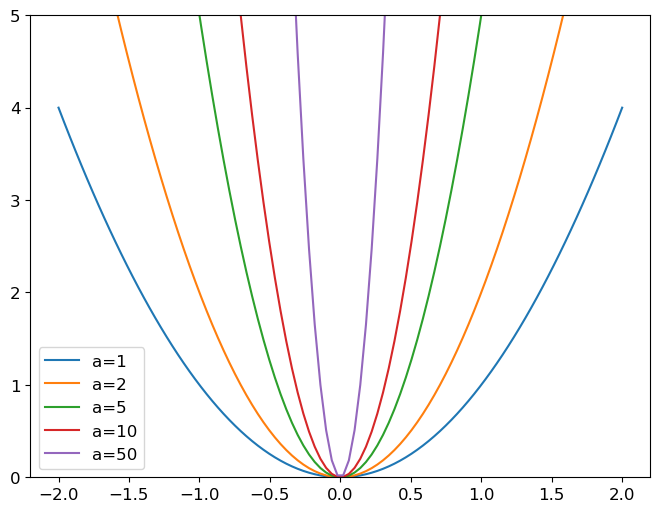

In [50]:
#hide_input
#id parabolas
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

```python
loss_with_wd = loss + wd * (parameters**2).sum()
```


in practice it's very inefficient to calc that big a sum and add to loss, but adding our big sum is actually the same operation as:

```python
parameters.grad += wd * 2 * parameters
```

In practice it's just a number we choose, so we don't even have to calc. that, just pick a number 2x as big

In [51]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.935754,0.948595,00:07
1,0.877064,0.874540,00:06
2,0.709078,0.834110,00:06
3,0.599683,0.822206,00:06
4,0.473438,0.823531,00:06


### Creating Our Own Embedding Module

Recreating `DotProductBias` without `Embedding` class

Optimizers require that they can get all the parameters of a model from the module's `parameters` method

This doesn't happen fully automatically so we're going to do it

If we add a tensor named *module* it will not be included in the parameters

In [52]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

In [53]:
L(T().parameters())

(#0) []

In [54]:
L(T().a)

(#1) [tensor([1., 1., 1.])]

To tell `T` we want it to treat our ones as a parameter, we have to wrap it in the `nn.Parameter` class
- This automatically calls `requires_grad_` but otherwise just serves as a marker to show what to include in parameters

In [55]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

All pytorch modules use `nn.Parameter` for any trainable parameters -- so we haven't needed to explicitly call it up until now

In [57]:
L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [58]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.9520],
        [ 0.8175],
        [-0.6235]], requires_grad=True)]

In [65]:
L(nn.Linear(3,5, bias=False).parameters())

(#1) [Parameter containing:
tensor([[-0.0585, -0.2457, -0.3105],
        [-0.4361, -0.4388,  0.4298],
        [ 0.0672,  0.0334,  0.2731],
        [ 0.2256, -0.5489,  0.3154],
        [-0.4222, -0.5152, -0.1622]], requires_grad=True)]

In [66]:
type(t.a.weight)

torch.nn.parameter.Parameter

We can create a tensor as a parameter, with random initialization, like so:

In [71]:
nn.Parameter(torch.zeros(5, 4))

Parameter containing:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], requires_grad=True)

In [67]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.1))

In [77]:
pb_create_params = create_params([1,2,3])
pb_create_params

Parameter containing:
tensor([[[-0.0079, -0.1296,  0.3168],
         [-0.0464, -0.2241,  0.0710]]], requires_grad=True)

In [79]:

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)
     

In [80]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [81]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.976546,0.990760,00:08
1,0.839526,0.864509,00:07
2,0.679322,0.842690,00:07
3,0.497363,0.842386,00:07
4,0.398364,0.844305,00:07


### Interpreting Embeddings and Biases